 # Scenario 5.1 - RMC Search

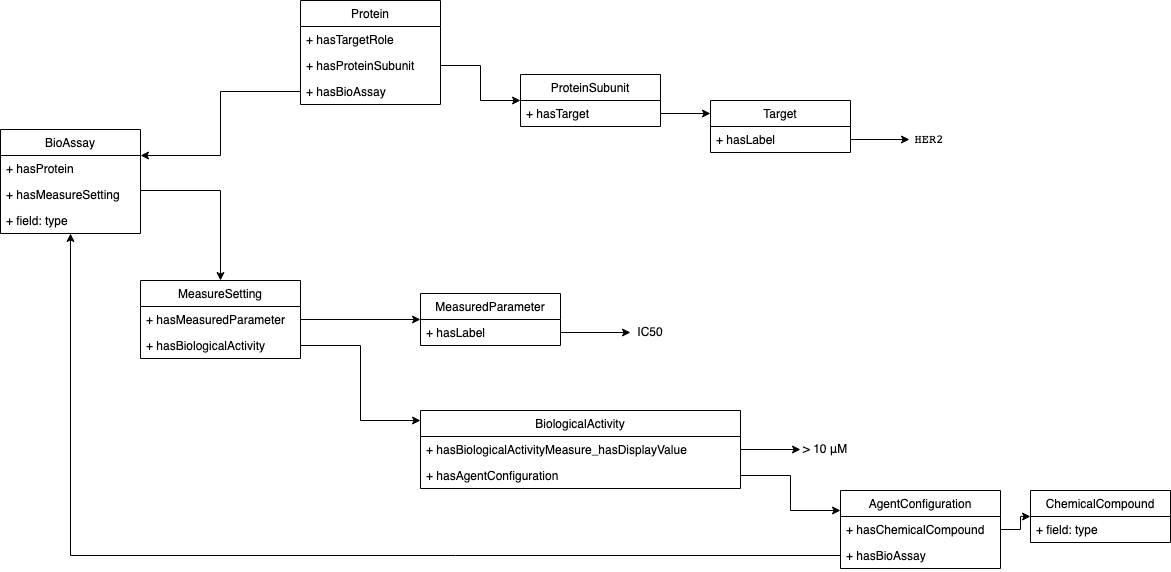

In [1]:
from IPython.display import Image
Image("RMC.png")

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import countDistinct
from pyspark import SparkContext, StorageLevel
import socket

hdfs_path = "hdfs://demo-full-load-hdfs-namenode:8020"
target_path          = hdfs_path + '/reaxys/elsevier-csv-reaxys-target_deduplicated/*.csv'
protein_path = hdfs_path + '/reaxys/elsevier-csv-reaxys-protein_deduplicated/*.csv'
protein_subunit_path = hdfs_path + '/reaxys/elsevier-csv-reaxys-proteinsubunit_deduplicated/*.csv'
bioassay_path = hdfs_path + '/reaxys/elsevier-csv-reaxys-bioassay_deduplicated/*.csv'
measuredparameter_path = hdfs_path + '/reaxys/elsevier-csv-reaxys-measuredparameter_deduplicated/*.csv'
measuresetting_path = hdfs_path + '/reaxys/elsevier-csv-reaxys-measuresettings_deduplicated/*.csv'

biological_activity_path = hdfs_path + '/reaxys/elsevier-csv-reaxys-biologicalactivity_deduplicated/*.csv'
agent_configuration_path = hdfs_path + '/reaxys/elsevier-csv-reaxys-agentconfiguration_deduplicated/*.csv'
chemical_compound_path = hdfs_path + '/reaxys/elsevier-csv-reaxys-chemicalcompound_deduplicated/*.csv'
chemical_compound_displayname_path = hdfs_path + '/reaxys/elsevier-csv-reaxys-chemicalcompoundname_deduplicated/*.csv'

# prevent error on rerunning if session is still alive
if 'sc' in globals():
    sc.stop()
    
# most configuration of the sparksession is done for you in the back
application_name = 'Use case 5 - RMC'

sparkSession = SparkSession.builder.appName("Use case 1.1")\
                           .config('spark.executor.memory', '4g')\
                           .config('spark.executor.instances', '5')\
                           .config('spark.sql.shuffle.partitions', '50')\
                           .config('spark.driver.memory', '4g')\
                           .config('spark.executor.cores', '3')\
                           .config('spark.driver.host', socket.gethostbyname(socket.gethostname()))\
                           .getOrCreate()

sc = sparkSession.sparkContext
sc

<SparkContext master=k8s://https://kubernetes.default.svc.cluster.local:443 appName=Use case 1.1>

In [3]:
import pprint
from IPython.display import Markdown, display, HTML

protein = sparkSession \
            .read \
            .option("header","true") \
            .csv(protein_path)\
            .na.drop(subset=["hasTargetRole"])\
            .select(['Protein','hasMeasureSettings','hasTargetRole',\
                     'hasProteinSubunit','hasAgentConfiguration',\
                     'hasBioassay','hasActivitySite'])

target = sparkSession \
            .read \
            .option("header","true") \
            .csv(target_path) \
            .withColumnRenamed("hasName","targetName")

target = target.alias('target')


protein_subunit = sparkSession \
            .read \
            .option("header","true") \
            .csv(protein_subunit_path)


protein = protein.alias('protein')

bioassay = sparkSession \
            .read \
            .option("header","true") \
            .csv(bioassay_path)\
            .na.drop(subset=["hasMeasureSettings"])
            
bioassay = bioassay.alias('bioassay')

measuredparameter = sparkSession \
            .read \
            .option("header","true") \
            .csv(measuredparameter_path)
            
measuredparameter = measuredparameter.alias('measuredparameter')

measuresetting = sparkSession \
            .read \
            .option("header","true") \
            .csv(measuresetting_path)
            
measuresetting = measuresetting.alias('measuresetting')


biological_activity = sparkSession \
            .read \
            .option("header","true") \
            .csv(biological_activity_path)
            
biological_activity = biological_activity.alias('biological_activity')


agent_configuration = sparkSession \
            .read \
            .option("header","true") \
            .csv(agent_configuration_path)
            
agent_configuration = agent_configuration.alias('agent_configuration')

chemical_compound = sparkSession \
            .read \
            .option("header","true") \
            .csv(chemical_compound_path)
            
chemical_compound = chemical_compound.alias('chemical_compound')

chemical_compound_displayname = sparkSession \
            .read \
            .option("header","true") \
            .csv(chemical_compound_displayname_path)
            
chemical_compound_displayname = chemical_compound_displayname.alias('chemical_compound_displayname')



First we extract the _MeasuredParameter_ for the *IC50*.

In [4]:
ic50_id = measuredparameter\
    .filter(measuredparameter.hasLabel.like('IC50'))\
    .select(['MeasuredParameter','hasLabel'])\
    .take(1)[0].MeasuredParameter
display(ic50_id)

'https://data.elsevier.com/lifescience/entity/reaxys/measuredparameter/900'

Once we have the id for the *IC50* _MeasuredParameter_ we search for a subset of _Target_ of interest.

Then we extract all _ProteinSubunit_ that has as a _Target_ one of our focused _Target_.

In [5]:
from pyspark.sql.functions import upper

focused_targets = target.filter(upper(target.hasLabel).contains('HER2'))\
    .select(['Target','hasLabel'])\
    .dropDuplicates()\

focused_protein_subunit = protein_subunit\
    .join(focused_targets , focused_targets.Target == protein_subunit.hasTarget)\
    .select(['ProteinSubunit','Target','hasLabel'])\
    .dropDuplicates()\

focused_targets.show(30,truncate=False)

+----------------------------------------------------------------+-----------------------------------------------+
|Target                                                          |hasLabel                                       |
+----------------------------------------------------------------+-----------------------------------------------+
|https://data.elsevier.com/lifescience/entity/reaxys/target/71758|HER2 (Tyr1248)                                 |
|https://data.elsevier.com/lifescience/entity/reaxys/target/8024 |Her2 peptide                                   |
|https://data.elsevier.com/lifescience/entity/reaxys/target/88617|HER2 InsYVMA                                   |
|https://data.elsevier.com/lifescience/entity/reaxys/target/89006|SypHer2                                        |
|https://data.elsevier.com/lifescience/entity/reaxys/target/71757|HER2( Tyr 1221/1222)                           |
|https://data.elsevier.com/lifescience/entity/reaxys/target/77105|Human epiderma

In [6]:
focused_protein_subunit.show(80, truncate=False)

+-----------------------------------------------------------------------------+----------------------------------------------------------------+-----------------------------------------------+
|ProteinSubunit                                                               |Target                                                          |hasLabel                                       |
+-----------------------------------------------------------------------------+----------------------------------------------------------------+-----------------------------------------------+
|https://data.elsevier.com/lifescience/entity/reaxys/proteinsubunit/1647214800|https://data.elsevier.com/lifescience/entity/reaxys/target/65378|HER2 (human epidermal growth factor receptor 2)|
|https://data.elsevier.com/lifescience/entity/reaxys/proteinsubunit/1451776450|https://data.elsevier.com/lifescience/entity/reaxys/target/8024 |Her2 peptide                                   |
|https://data.elsevier.com/lifescie

We proceed to extract all _Protein_ with a _ProteinSubunit_ of interest. 

From the _Protein_ we traverse and get the _BioAssay_ and filter out all _MeasureSettings_ for *IC50* as a _MeasuredParameter__ and explode all links to _BiologicalActivity_ .


In [7]:
%%time
from pyspark.sql.functions import split, explode
from pyspark.sql.functions import col

info_p = protein\
    .join(focused_protein_subunit, protein.hasProteinSubunit == focused_protein_subunit.ProteinSubunit)\
    .join(bioassay, protein.hasBioassay == bioassay.Bioassay)\
    .join(measuresetting , bioassay.hasMeasureSettings == measuresetting.MeasureSettings )\
    .withColumn("hasBiologicalActivity", explode(split("hasBiologicalActivity", "\|\|")))

info_c = biological_activity\
    .join(info_p , info_p.hasBiologicalActivity == biological_activity.BiologicalActivity)\
    .join(agent_configuration , biological_activity.hasAgentConfiguration == agent_configuration.AgentConfiguration)\
    .join(chemical_compound_displayname , agent_configuration.hasChemicalCompound == chemical_compound_displayname.hasChemicalCompound)\
    .join(measuredparameter , measuresetting.hasMeasuredParameter == measuredparameter.MeasuredParameter)\
    .select(col('target.hasLabel').alias("TargetName"),\
            col('chemical_compound_displayname.hasName').alias("ChemicalCompoundName"), \
            col('hasBiologicalActivityMeasure_hasStandardValue').alias("StandardValue"), \
            col('hasBiologicalActivityMeasure_hasValueUnit').alias("Unit"),\
            col('measuredparameter.hasLabel').alias("Parameter"),\
)
    
info_c.toPandas()

CPU times: user 316 ms, sys: 29.3 ms, total: 345 ms
Wall time: 56.3 s


,TargetName,ChemicalCompoundName,StandardValue,Unit,Parameter
0,HER2 (human epidermal growth factor receptor 2),NVP-AEW541,1.0E-5,&#956;M,IC50
1,HER2 (human epidermal growth factor receptor 2),NVP-AEW541,1.0E-5,&#956;M,IC50
2,HER2 (human epidermal growth factor receptor 2),AEW541,1.0E-5,&#956;M,IC50
3,HER2 (human epidermal growth factor receptor 2),AEW-541,1.0E-5,&#956;M,IC50


In [8]:
%%time

from pyspark.sql.functions import split, explode
fprotein = protein\
    .join(focused_protein_subunit, protein.hasProteinSubunit == focused_protein_subunit.ProteinSubunit)\
    .join(bioassay, protein.hasBioassay == bioassay.Bioassay)\
    .join(measuresetting , bioassay.hasMeasureSettings == measuresetting.MeasureSettings )\
    .filter(measuresetting.hasMeasuredParameter == ic50_id)\
    .dropDuplicates()\
    .withColumn("hasBiologicalActivity", explode(split("hasBiologicalActivity", "\|\|")))

#fprotein.toPandas()
   

CPU times: user 2.48 ms, sys: 347 µs, total: 2.82 ms
Wall time: 88.3 ms


We proceed to follow the links from _BiologicalActivity_ to _AgentConfiguration_ to _ChemicalCompound_, and let's extract all _BiologicalActivities_ values .

In [9]:
%%time
from pyspark.sql.functions import col

focused_chemical_compounds = biological_activity\
    .join(fprotein , fprotein.hasBiologicalActivity == biological_activity.BiologicalActivity)\
    .join(agent_configuration , biological_activity.hasAgentConfiguration == agent_configuration.AgentConfiguration)\
    .join(chemical_compound_displayname , agent_configuration.hasChemicalCompound == chemical_compound_displayname.hasChemicalCompound)\
    .select(col('BiologicalActivity'), \
            col('agent_configuration.hasChemicalCompound').alias("ChemicalCompound"),\
            col('target.hasLabel').alias("TargetName"),\
            col('chemical_compound_displayname.hasName').alias("ChemicalCompoundName"), \
            col('hasBiologicalActivityMeasure_hasDisplayValue').alias("IC50-Display"), \
            col('hasBiologicalActivityMeasure_hasValue').alias("IC50"),\
            col('biological_activity.hasAgentConfiguration').alias("AgentConfiguration"))\
    .dropDuplicates(["ChemicalCompound"])\
    
focused_chemical_compounds.toPandas()

CPU times: user 16.6 ms, sys: 1.01 ms, total: 17.6 ms
Wall time: 1min 5s


,BiologicalActivity,ChemicalCompound,TargetName,ChemicalCompoundName,IC50-Display,IC50,AgentConfiguration
0,https://data.elsevier.com/lifescience/entity/r...,https://data.elsevier.com/lifescience/entity/r...,HER2 (human epidermal growth factor receptor 2),AEW-541,> 10 &#956;M,10.0,https://data.elsevier.com/lifescience/entity/r...


Let's extract all other _Target_ hit by the same _ChemicalCompound_ along with all the *IC50* values.

In [10]:
%%time
from pyspark.sql.functions import col

affecting_chemical_compounds = focused_chemical_compounds\
    .select(col('ChemicalCompound'))\
    .join(agent_configuration , agent_configuration.hasChemicalCompound == col('ChemicalCompound') )\
    .join(chemical_compound_displayname , col('ChemicalCompound') == chemical_compound_displayname.hasChemicalCompound)\
    .join(biological_activity , biological_activity.hasAgentConfiguration == agent_configuration.AgentConfiguration)\
    .join(measuresetting , biological_activity.hasMeasureSettings == measuresetting.MeasureSettings )\
    .filter(measuresetting.hasMeasuredParameter == ic50_id)\
    .join(bioassay , bioassay.hasMeasureSettings == measuresetting.MeasureSettings )\
    .join(protein , protein.Protein == bioassay.hasProtein)\
    .join(protein_subunit, protein.hasProteinSubunit == protein_subunit.ProteinSubunit)\
    .join(target , target.Target == protein_subunit.hasTarget)\
    .select(col('ChemicalCompound'),\
            col('target.hasLabel').alias("TargetName"),\
            col('chemical_compound_displayname.hasName').alias("ChemicalCompoundName"), \
            col('hasBiologicalActivityMeasure_hasDisplayValue').alias("IC50-Display"), \
            col('hasBiologicalActivityMeasure_hasValue').alias("IC50"),\
            col('biological_activity.hasAgentConfiguration').alias("AgentConfiguration"))\
    .dropDuplicates()

    

CPU times: user 5.74 ms, sys: 382 µs, total: 6.12 ms
Wall time: 380 ms


In [11]:
%%time

results = affecting_chemical_compounds.toPandas()

CPU times: user 20.6 ms, sys: 774 µs, total: 21.3 ms
Wall time: 1min 59s


In [12]:
results.to_csv('usecase5_1.csv')

<ipython-input-13-8899cdc06c24>:31: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


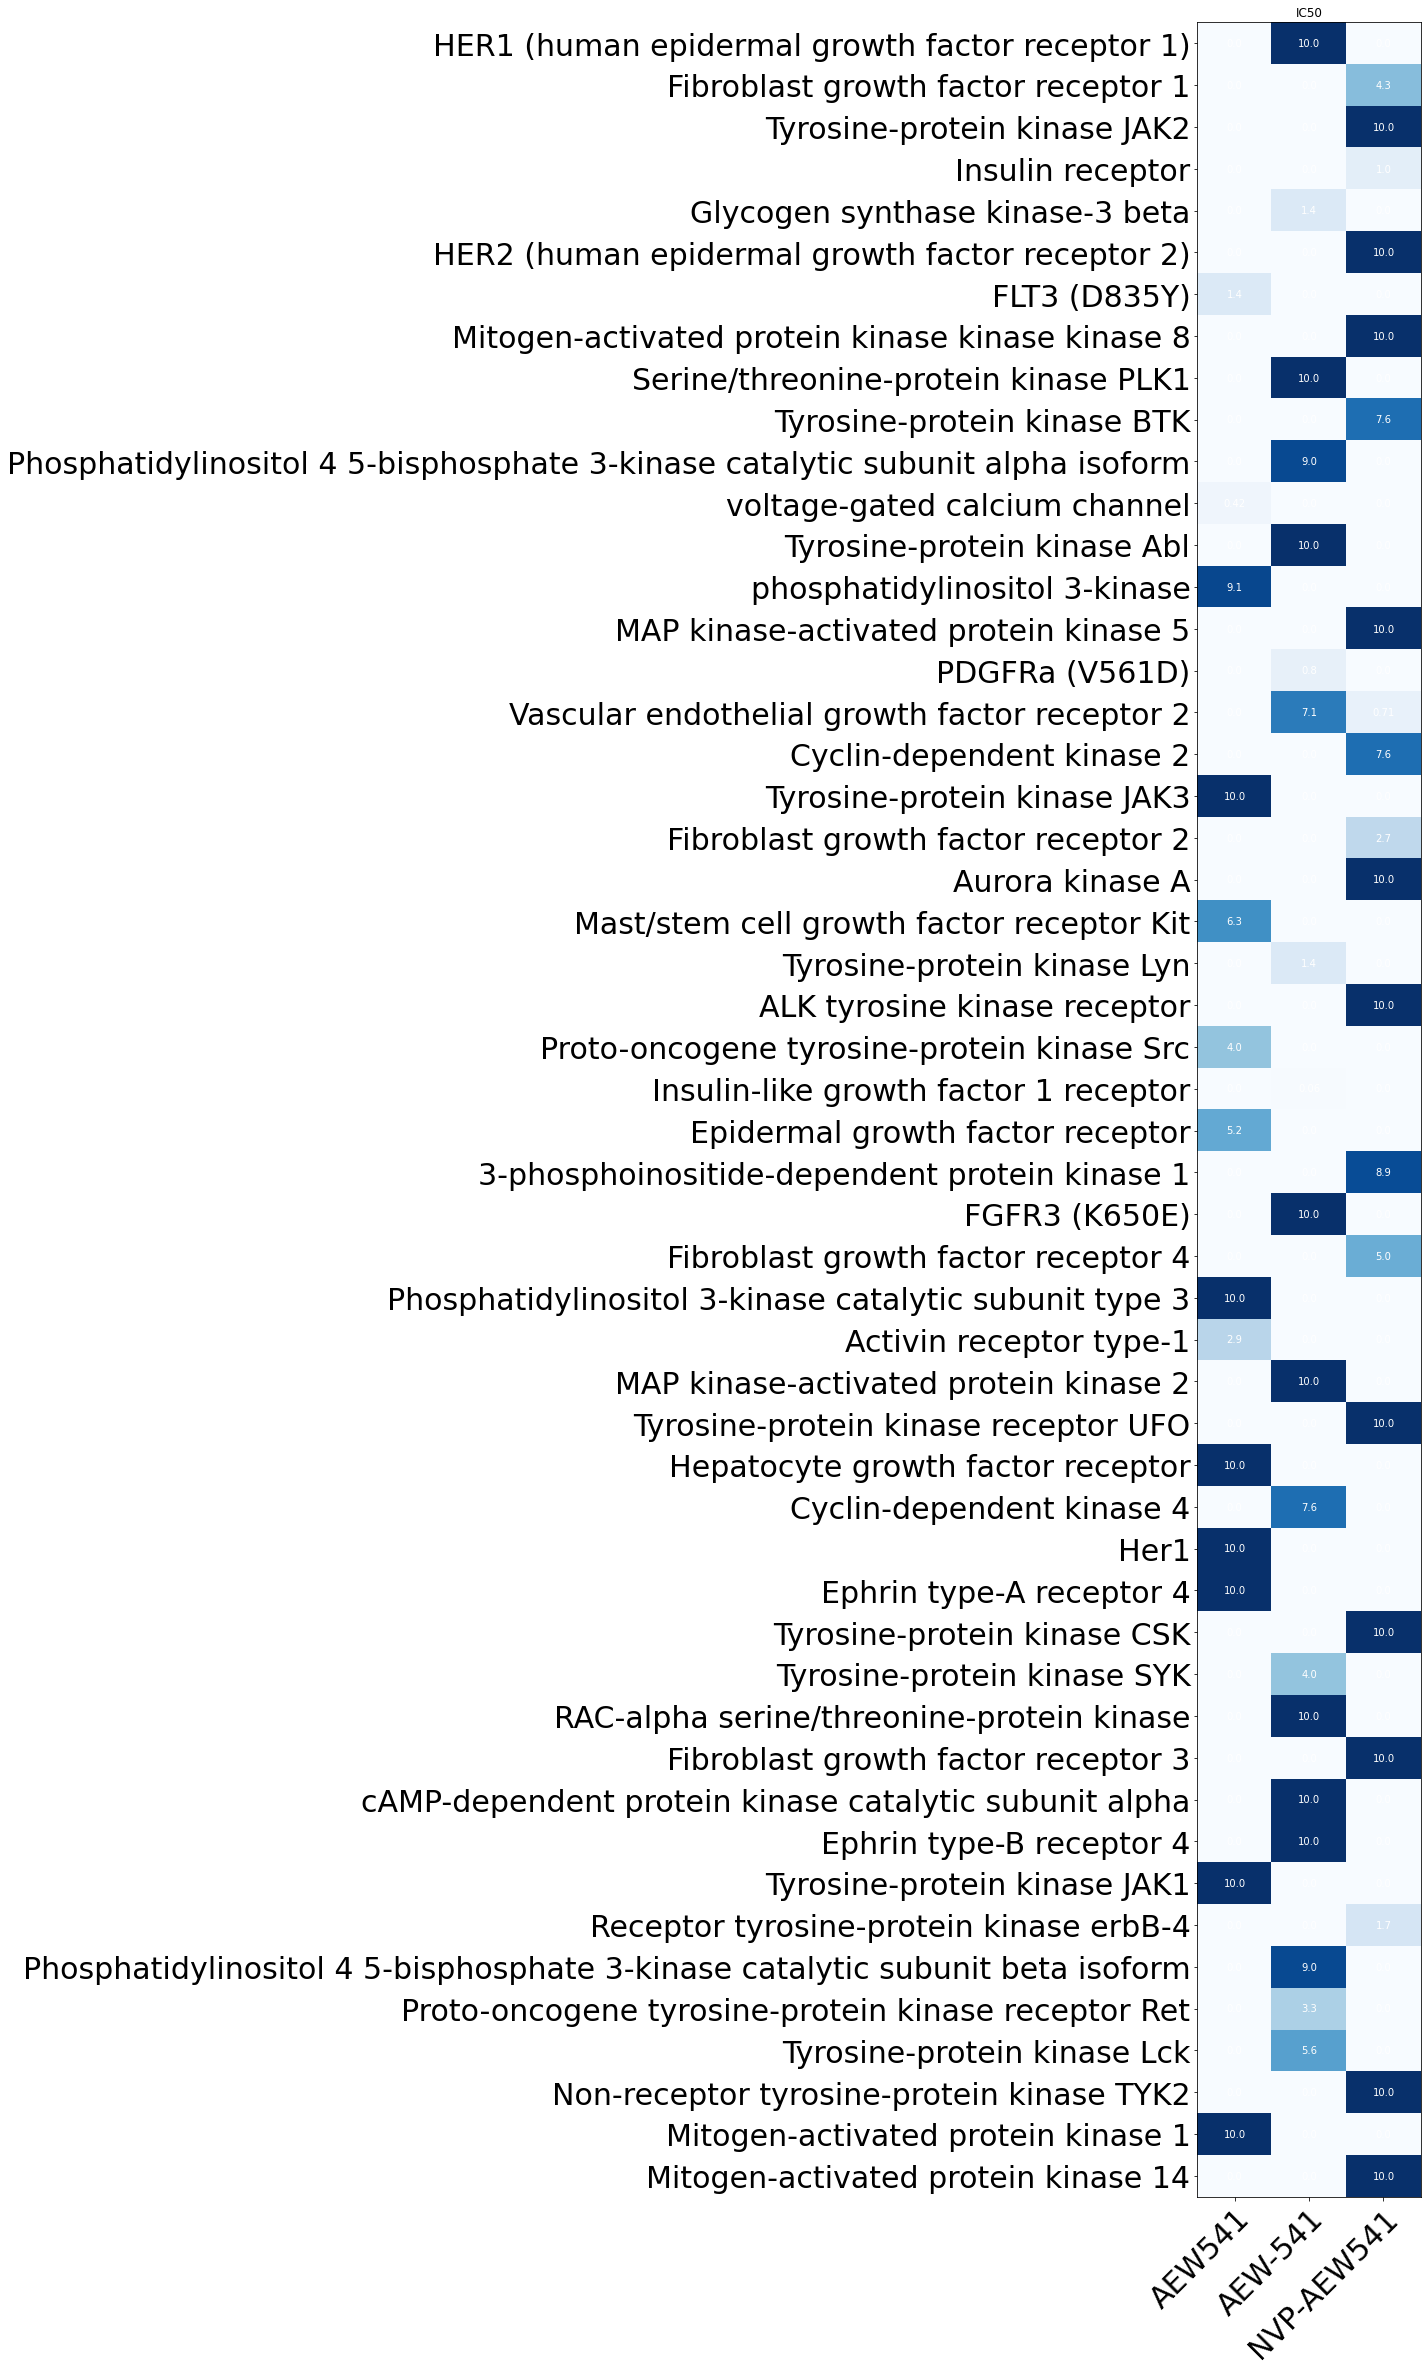

In [13]:
!pip install matplotlib

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

def plotHeatMap(ds , x , y , vals):
    xlabels = set(ds[x])
    ylabels = set(ds[y])
    data = np.zeros(shape = (len(xlabels), len(ylabels)))
    for xi,xii in zip(xlabels, range(len(xlabels))):
        for yi,yii in zip(ylabels, range(len(ylabels))):
            datav = ds[((ds[x].eq(xi)) & \
                            (ds[y].eq(yi)))][vals].values
            if len(datav) >0:
                data[xii,yii] = datav[0]
    fig, ax = plt.subplots(figsize=(4,40))
    im = ax.imshow(data, interpolation='nearest', aspect='auto',cmap=plt.get_cmap('Blues'))
    ax.set_xticks(np.arange(len(ylabels)))
    ax.set_yticks(np.arange(len(xlabels)))
    ax.set_xticklabels(ylabels, fontsize=30)
    ax.set_yticklabels(xlabels, fontsize=30)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    for i in range(len(xlabels)):
        for j in range(len(ylabels)):
            text = ax.text(j, i, data[i, j],
                           ha="center", va="center", color="w")
    ax.set_title("IC50")
    fig.tight_layout()
    plt.show()

    
pd.set_option('display.max_rows', None)
presults = results[results['IC50-Display'].str.contains('&#956;M')]
presults = presults.drop_duplicates(subset=['TargetName' , 'ChemicalCompound' , 'IC50'])

plotHeatMap(presults , 'TargetName' ,'ChemicalCompoundName'   , 'IC50')
